# Algoritmo de Conjugate_grandient_method

### Función de prueba

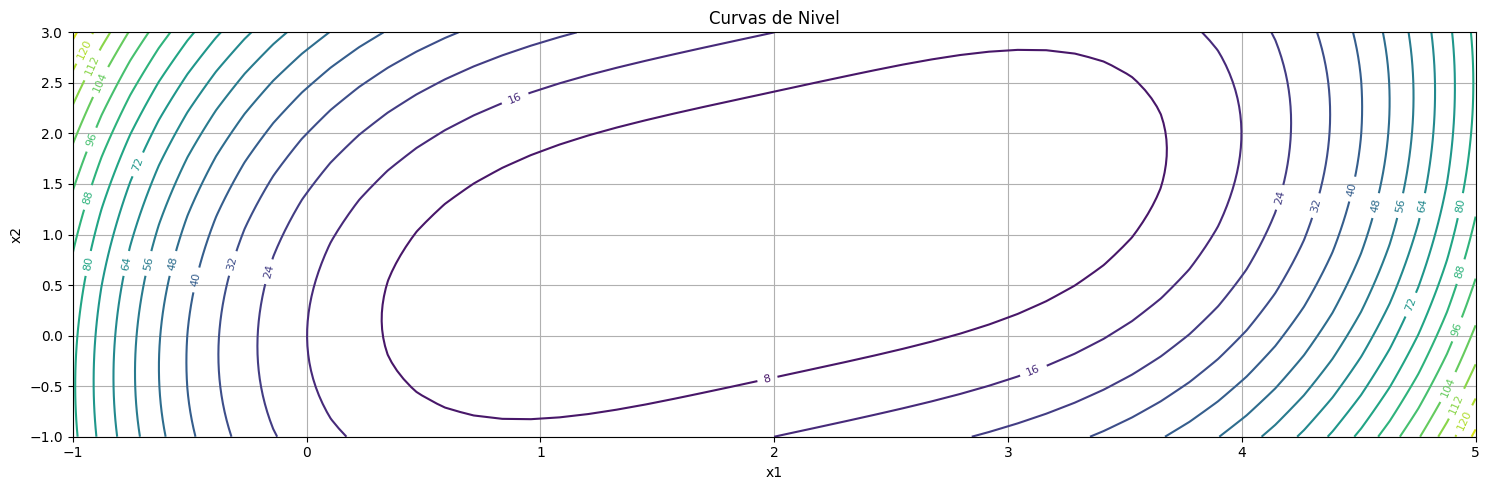

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def quasiconvex_function(x):
  """
  Función de dos variables: f(x1, x2) = (x1 - 2)^4 + (x1 - 2*x2)^2
  Para graficar, usaremos x1 = x y x2 = 0 como caso particular
  """
  if isinstance(x, (list, tuple, np.ndarray)) and len(x) == 2:
    x1, x2 = x
    return (x1 - 2)**4 + (x1 - 2*x2)**2
  else:
    # Para compatibilidad con el código existente, asumimos x2 = 0
    x1 = x
    x2 = 0
    return (x1 - 2)**4 + (x1 - 2*x2)**2

# Crear gráfica 3D de la función de dos variables
fig = plt.figure(figsize=(15, 5))

# Subplot 2: Curvas de nivel
ax2 = fig.add_subplot(111)
x1_range = np.linspace(-1, 5, 50)
x2_range = np.linspace(-1, 3, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = (X1 - 2)**4 + (X1 - 2*X2)**2

contour = ax2.contour(X1, X2, Z, levels=20)
ax2.clabel(contour, inline=True, fontsize=8)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Curvas de Nivel')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Desarrollo del algoritmo

In [2]:
def gradient(x, h=1e-8):
    """Calcula el gradiente usando diferencias finitas centrales"""
    x1, x2 = x
    
    # Diferencia finita para x1
    df_dx1 = (quasiconvex_function([x1 + h, x2]) - quasiconvex_function([x1 - h, x2])) / (2 * h)
    
    # Diferencia finita para x2
    df_dx2 = (quasiconvex_function([x1, x2 + h]) - quasiconvex_function([x1, x2 - h])) / (2 * h)
    
    return np.array([df_dx1, df_dx2])

def hessian(x, h=1e-5):
    """Calcula la matriz Hessiana usando diferencias finitas"""
    x1, x2 = x
    
    # Segundas derivadas parciales
    # d2f/dx1^2
    d2f_dx1_dx1 = (quasiconvex_function([x1 + h, x2]) - 2*quasiconvex_function([x1, x2]) + quasiconvex_function([x1 - h, x2])) / (h**2)
    
    # d2f/dx2^2
    d2f_dx2_dx2 = (quasiconvex_function([x1, x2 + h]) - 2*quasiconvex_function([x1, x2]) + quasiconvex_function([x1, x2 - h])) / (h**2)
    
    # d2f/dx1dx2 (derivada mixta)
    d2f_dx1_dx2 = (quasiconvex_function([x1 + h, x2 + h]) - quasiconvex_function([x1 + h, x2 - h]) - 
                    quasiconvex_function([x1 - h, x2 + h]) + quasiconvex_function([x1 - h, x2 - h])) / (4 * h**2)
    
    return np.array([[d2f_dx1_dx1, d2f_dx1_dx2],
                    [d2f_dx1_dx2, d2f_dx2_dx2]])

def is_positive_definite(matrix):
    """Verifica si una matriz es definida positiva usando Cholesky"""
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False
    
def gold_section(x, d, initial_step=1.0, incertidumbre=1e-6):
    """
    Búsqueda lineal usando sección áurea para encontrar el paso óptimo
    
    Parámetros:
    x: punto actual [x1, x2]
    d: dirección de búsqueda [d1, d2]
    initial_step: paso inicial para establecer el intervalo
    incertidumbre: tolerancia para el intervalo final
    
    Retorna:
    lambda_opt: paso óptimo
    """
    # Función objetivo en términos del paso lambda
    def f_lambda(lam):
        return quasiconvex_function(x + lam * d)
    
    # Establecer intervalo inicial [a, b]
    # Comenzamos con un intervalo pequeño y lo expandimos si es necesario
    a = 0.0
    b = initial_step
    
    # Verificar que tenemos un intervalo válido expandiéndolo si es necesario
    # Si f(b) > f(a), el mínimo puede estar en [a, b]
    # Si f(b) < f(a), expandir b
    while f_lambda(b) < f_lambda(a):
        a = b
        b = 2 * b
        if b > 100:  # Evitar expansión infinita
            break
    
    # Ahora aplicar sección áurea en el intervalo [a, b]
    l = incertidumbre
    
    # Definición de la razón áurea
    aurea = 0.618033988749895
    
    # Definición de puntos de prueba
    lambda_1 = a + (1 - aurea) * (b - a)
    mu_1 = a + aurea * (b - a)
    
    while (b - a) > l:
        if f_lambda(lambda_1) > f_lambda(mu_1):
            a = lambda_1
            lambda_1 = mu_1
            mu_1 = a + aurea * (b - a)
        else:
            b = mu_1
            mu_1 = lambda_1
            lambda_1 = a + (1 - aurea) * (b - a)
    
    # Resultado
    lambda_opt = (a + b) / 2
    
    return lambda_opt

In [3]:
def conjugate_gradient_fletcher_reeves(x0, epsilon=1e-6, max_iter=1000):
    """
    Implementación del método de Gradiente Conjugado (Fletcher-Reeves)
    
    Parámetros:
    x0: punto inicial [x1, x2]
    epsilon: tolerancia de convergencia
    max_iter: máximo número de iteraciones
    
    Retorna:
    dict con el resultado de la optimización
    """
    
    # Inicialización
    x = np.array(x0, dtype=float)
    n = len(x)  # dimensión del problema
    
    # Evaluar gradiente inicial
    g = gradient(x)
    
    # Establecer dirección inicial
    d = -g
    
    # Variables para almacenar el historial
    history = {
        'points': [x.copy()],
        'function_values': [quasiconvex_function(x)],
        'gradients': [g.copy()],
        'directions': [d.copy()],
        'step_sizes': []
    }
    
    k = 1  # iteración total
    j = 1  # iteración dentro del ciclo de n pasos
    
    # Bucle principal
    while np.linalg.norm(g) > epsilon and k < max_iter:
        
        # Paso 1: Búsqueda lineal
        lambda_j = gold_section(x, d)
        
        # Paso 2: Actualizar el punto
        x_new = x + lambda_j * d
        
        # Paso 3: Calcular nuevo gradiente
        g_new = gradient(x_new)
        
        # Guardar información del paso
        history['step_sizes'].append(lambda_j)
        history['points'].append(x_new.copy())
        history['function_values'].append(quasiconvex_function(x_new))
        history['gradients'].append(g_new.copy())
        
        # Criterio de parada
        if np.linalg.norm(g_new) < epsilon:
            break
            
        # Actualizar posición
        x = x_new
        
        if j < n:
            # Paso 4: Calcular parámetro de conjugación (Fletcher-Reeves)
            alpha_j = np.dot(g_new, g_new) / np.dot(g, g)
            
            # Paso 5: Actualizar dirección de búsqueda
            d_new = -g_new + alpha_j * d
            
            # Actualizar variables
            g = g_new
            d = d_new
            j += 1
        else:
            # Reiniciar: nueva dirección es el negativo del gradiente
            d = -g_new
            g = g_new
            j = 1  # reiniciar contador de ciclo
            
        history['directions'].append(d.copy())
        k += 1
    
    # Preparar resultados
    result = {
        'optimal_point': x,
        'optimal_value': quasiconvex_function(x),
        'gradient_norm': np.linalg.norm(g),
        'iterations': k - 1,
        'converged': np.linalg.norm(g) <= epsilon,
        'history': history
    }
    
    # Imprimir resumen
    print(f"\n=== GRADIENTE CONJUGADO (FLETCHER-REEVES) ===")
    print(f"Punto inicial: [{x0[0]:.3f}, {x0[1]:.3f}]")
    print(f"Punto final: [{result['optimal_point'][0]:.6f}, {result['optimal_point'][1]:.6f}]")
    print(f"Valor de la función: {result['optimal_value']:.6e}")
    print(f"Norma del gradiente: {result['gradient_norm']:.6e}")
    print(f"Iteraciones: {result['iterations']}")
    print(f"Convergencia: {'Sí' if result['converged'] else 'No'}")
    
    return result


=== GRADIENTE CONJUGADO (FLETCHER-REEVES) ===
Punto inicial: [0.000, 3.000]
Punto final: [2.001949, 1.000980]
Valor de la función: 1.225830e-10
Norma del gradiente: 4.649259e-05
Iteraciones: 10
Convergencia: No


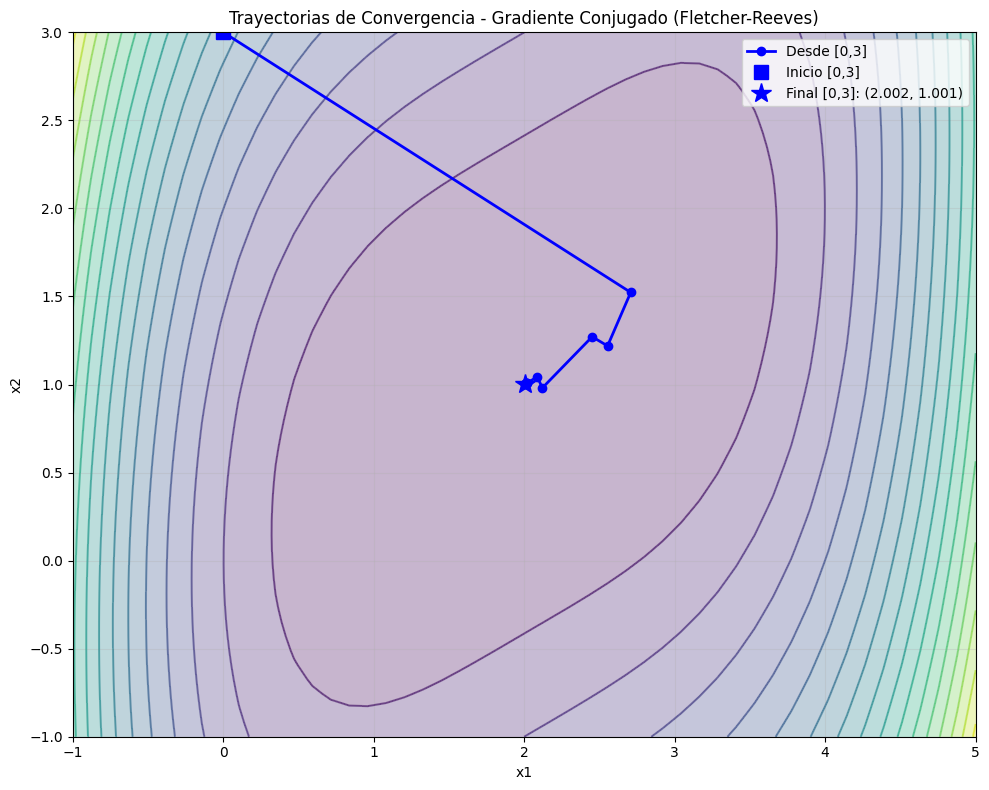


=== RESUMEN DE RESULTADOS ===
Punto Inicial   Solución Final       f(x) Final      Iteraciones 
----------------------------------------------------------------------
[0, 3]          [2.002, 1.001]    1.225830e-10    10          


In [4]:
# Ejecutar con punto inicial [0, 3]
result_dfp = conjugate_gradient_fletcher_reeves([0, 3])

# Visualizar solo las trayectorias de convergencia
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Gráfico: Trayectorias sobre las curvas de nivel
ax.contour(X1, X2, Z, levels=20, alpha=0.6)
ax.contourf(X1, X2, Z, levels=20, alpha=0.3, cmap='viridis')

# Trayectoria desde [0, 3]
points = result_dfp['history']['points']
x_traj = [point[0] for point in points]
y_traj = [point[1] for point in points]
ax.plot(x_traj, y_traj, 'bo-', linewidth=2, markersize=6, label='Desde [0,3]')
ax.plot(x_traj[0], y_traj[0], 'bs', markersize=10, label='Inicio [0,3]')
ax.plot(x_traj[-1], y_traj[-1], 'b*', markersize=15, 
    label=f'Final [0,3]: ({result_dfp["optimal_point"][0]:.3f}, {result_dfp["optimal_point"][1]:.3f})')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Trayectorias de Convergencia - Gradiente Conjugado (Fletcher-Reeves)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla comparativa de resultados
print("\n=== RESUMEN DE RESULTADOS ===")
print(f"{'Punto Inicial':<15} {'Solución Final':<20} {'f(x) Final':<15} {'Iteraciones':<12}")
print("-" * 70)
print(f"[0, 3]          [{result_dfp['optimal_point'][0]:.3f}, {result_dfp['optimal_point'][1]:.3f}]    {result_dfp['optimal_value']:<15.6e} {result_dfp['iterations']:<12}")
